### 生成数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#np.random.seed(42)
n_samples = 1000
n_features = 200
mu = 0
mu2 = 1
sigma = 1
epsilon = 0.3
lam = 1

# Generate feature data X
X = np.random.randn(n_samples, n_features)
true_beta = np.random.randn(n_features)

### 正常LS预测

In [2]:
# Generate noise variable Z using the mixture distribution
u = np.random.rand(n_samples)
Z = np.zeros(n_samples)

# For each sample, decide from which distribution to draw
for i in range(n_samples):
    if u[i] < epsilon:
        Z[i] = np.random.normal(mu2, 3 * sigma)
    else:
        Z[i] = np.random.normal(mu, sigma)

# Sort Z according to u from smallest to largest
sorted_indices = np.argsort(u)
Z = Z[sorted_indices]
# Generate the target variable Y
Y = X.dot(true_beta) + Z

# split the data into training and test sets
train_size = int(0.7 * n_samples)
test_size = n_samples - train_size
X1, X_test = X[:train_size], X[train_size:]
Y1, Y_test = Y[:train_size], Y[train_size:]
X_test = np.random.randn(test_size, n_features)
Y_test = X_test.dot(true_beta) + np.random.normal(mu, sigma, test_size)

# beta = (X^T X)^-1 X^T Y
X_transpose = X1.T
X_transpose_X = X_transpose.dot(X1)
X_transpose_X_inv = np.linalg.inv(X_transpose_X)
X_transpose_Y = X_transpose.dot(Y1)
beta_hat_orignal = X_transpose_X_inv.dot(X_transpose_Y)
MSE_beta_hat_original = np.mean((beta_hat_orignal - true_beta) ** 2)
print('MSE of beta_hat_original:', MSE_beta_hat_original)
Y_resid = np.abs(Y1 - X1.dot(beta_hat_orignal))

# Predict on the test set
Y_test_pred = X_test.dot(beta_hat_orignal)

# Calculate residuals on the test set
Y_test_resid = Y_test - Y_test_pred

# Calculate MSE on the test set
MSE_test_original = np.mean(Y_test_resid ** 2)
print('MSE on test set:', MSE_test_original)

MSE of beta_hat_original: 0.009757996026562885
MSE on test set: 3.0595287471356882


## 去除最大的residual
### 一次删一个点
#### 每次进行平均时候不更新$\beta$

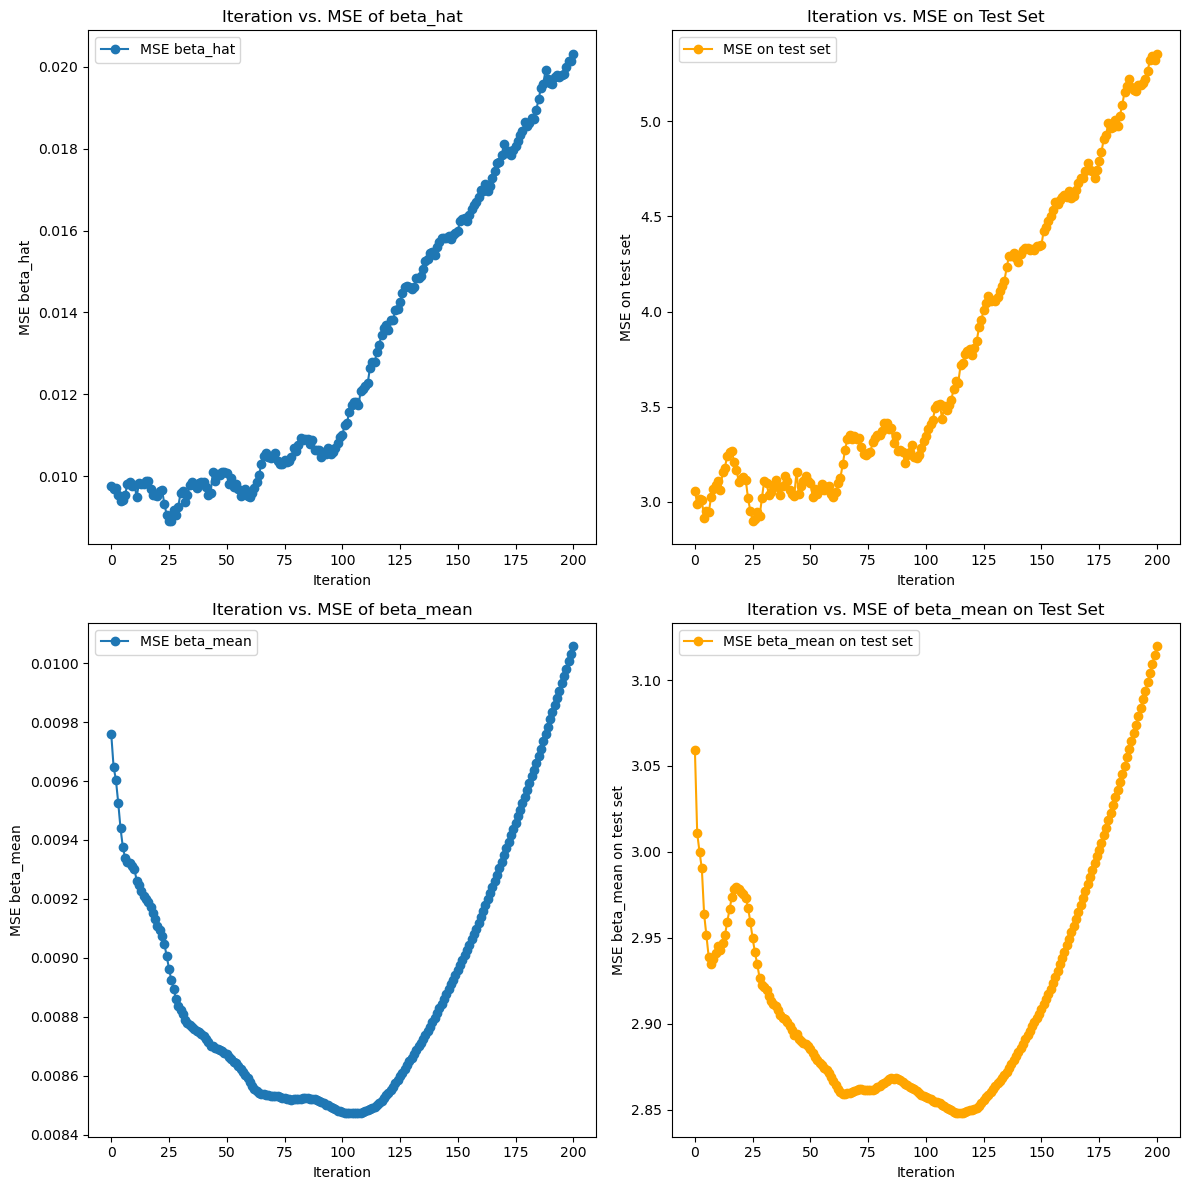

In [3]:
iter = 200
# Calculate residuals and set weights
weights = np.ones(train_size)
beta_history = [beta_hat_orignal]
MSE_history = [MSE_beta_hat_original]
MSE_test_history = [MSE_test_original]
MSE_beta_mean_history = [MSE_beta_hat_original]
MSE_beta_mean_test_history = [MSE_test_original]
beta_hat = beta_hat_orignal
for iteration in range(iter):  # Perform the process twice
    Y_resid = np.abs(Y1 - X1.dot(beta_hat))
    
    # Identify the index of the largest residual
    largest_residual_index = np.argmax(Y_resid * weights)
    
    # Set the weight of the largest residual to zero
    weights[largest_residual_index] = 0
    
    # Compute weighted OLS regression coefficients
    W = np.diag(weights)
    X_transpose_W = X1.T.dot(W)
    X_transpose_W_X = X_transpose_W.dot(X1)
    X_transpose_W_X_inv = np.linalg.inv(X_transpose_W_X)
    X_transpose_W_Y = X_transpose_W.dot(Y1)
    beta_hat = X_transpose_W_X_inv.dot(X_transpose_W_Y)
    beta_history.append(beta_hat)
    MSE_beta_hat = np.mean((beta_hat - true_beta) ** 2)
    MSE_history.append(MSE_beta_hat)
    # Predict on the test set
    Y_test_pred = X_test.dot(beta_hat)

    # Calculate residuals on the test set
    Y_test_resid = Y_test - Y_test_pred

    # Calculate MSE on the test set
    MSE_test = np.mean(Y_test_resid ** 2)
    MSE_test_history.append(MSE_test)

    beta_mean = np.mean(beta_history, axis=0)
    MSE_beta_mean = np.mean((beta_mean - true_beta) ** 2)
    MSE_beta_mean_history.append(MSE_beta_mean)
    Y_beta_mean_test_pred = X_test.dot(beta_mean)
    Y_beta_mean_test_resid = Y_test - Y_beta_mean_test_pred
    MSE_beta_mean_test = np.mean(Y_beta_mean_test_resid ** 2)
    MSE_beta_mean_test_history.append(MSE_beta_mean_test)

# 绘制迭代次数和MSE的关系图
iterations = list(range(iter+1))  # 包含初始值的0次迭代

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(iterations, MSE_history, marker='o', label='MSE beta_hat')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_hat')
plt.title('Iteration vs. MSE of beta_hat')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iterations, MSE_test_history, marker='o', label='MSE on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE on test set')
plt.title('Iteration vs. MSE on Test Set')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iterations, MSE_beta_mean_history, marker='o', label='MSE beta_mean')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean')
plt.title('Iteration vs. MSE of beta_mean')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iterations, MSE_beta_mean_test_history, marker='o', label='MSE beta_mean on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean on test set')
plt.title('Iteration vs. MSE of beta_mean on Test Set')
plt.legend()

plt.tight_layout()
plt.show()


##### gradient descent来更新

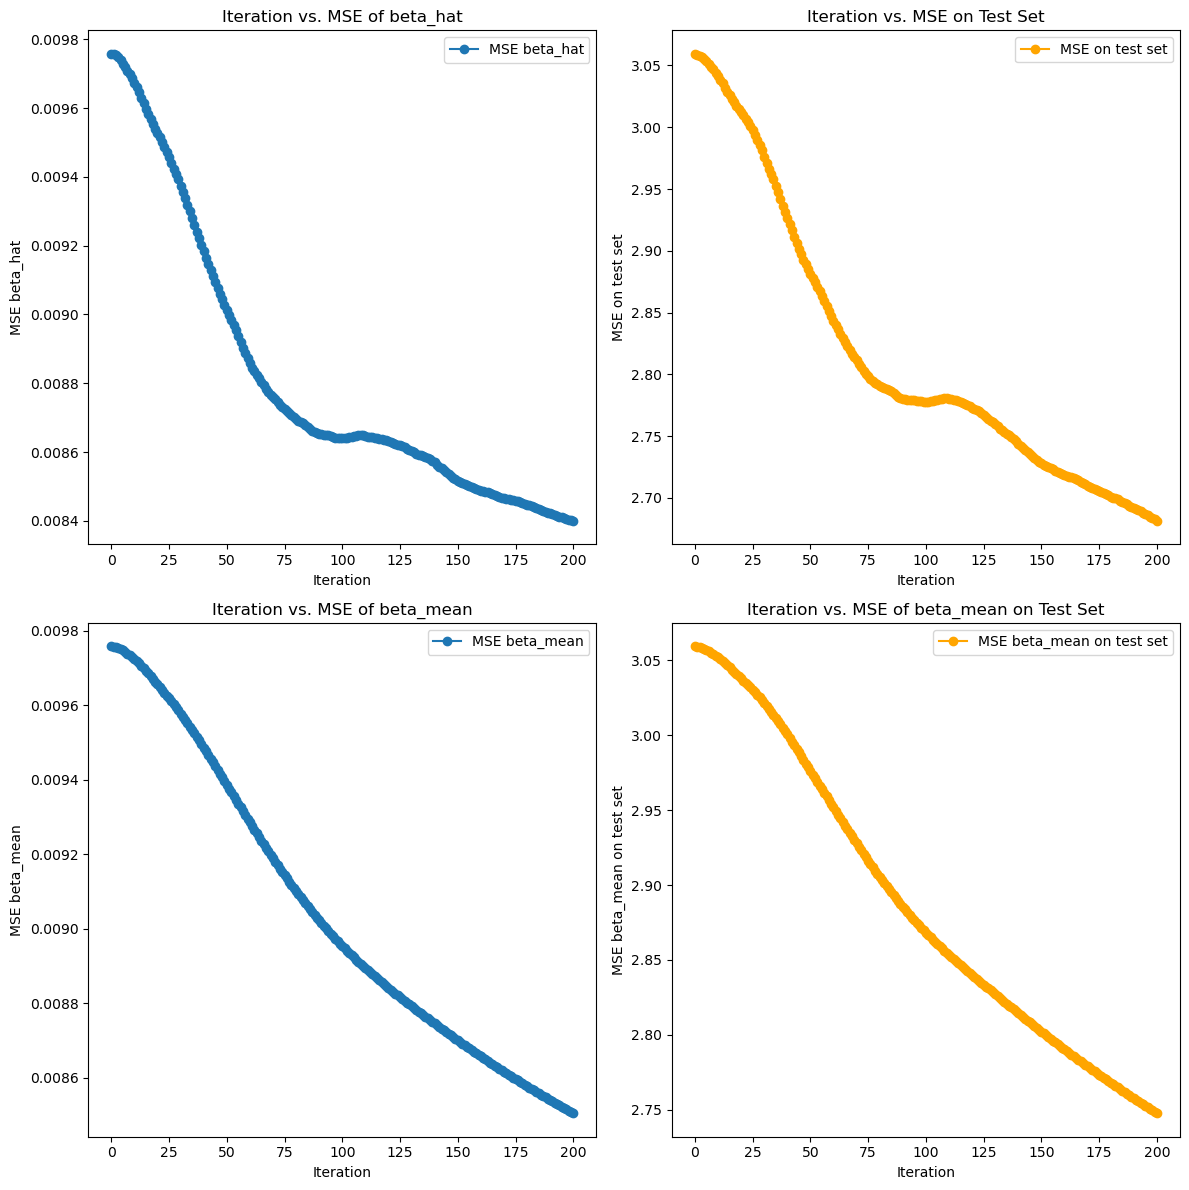

In [4]:
iter = 200
learning_rate = 0.01
# Calculate residuals and set weights
weights = np.ones(train_size)
beta_history = [beta_hat_orignal]
MSE_history = [MSE_beta_hat_original]
MSE_test_history = [MSE_test_original]
MSE_beta_mean_history = [MSE_beta_hat_original]
MSE_beta_mean_test_history = [MSE_test_original]
beta_hat = beta_hat_orignal
for iteration in range(iter):  # Perform the process twice
    Y_resid = np.abs(Y1 - X1.dot(beta_hat))
    
    # Identify the index of the largest residual
    largest_residual_index = np.argmax(Y_resid * weights)
    
    # Set the weight of the largest residual to zero
    weights[largest_residual_index] = 0
    
    # Compute weighted OLS regression coefficients
    weighted_resid = weights * (X1.dot(beta_hat) -Y1)
    gradient = 2 * X1.T.dot(weighted_resid) / len(Y1)
    beta_hat = beta_hat - learning_rate*gradient
    
    beta_history.append(beta_hat)
    MSE_beta_hat = np.mean((beta_hat - true_beta) ** 2)
    MSE_history.append(MSE_beta_hat)
    # Predict on the test set
    Y_test_pred = X_test.dot(beta_hat)

    # Calculate residuals on the test set
    Y_test_resid = Y_test - Y_test_pred

    # Calculate MSE on the test set
    MSE_test = np.mean(Y_test_resid ** 2)
    MSE_test_history.append(MSE_test)

    beta_mean = np.mean(beta_history, axis=0)
    MSE_beta_mean = np.mean((beta_mean - true_beta) ** 2)
    MSE_beta_mean_history.append(MSE_beta_mean)
    Y_beta_mean_test_pred = X_test.dot(beta_mean)
    Y_beta_mean_test_resid = Y_test - Y_beta_mean_test_pred
    MSE_beta_mean_test = np.mean(Y_beta_mean_test_resid ** 2)
    MSE_beta_mean_test_history.append(MSE_beta_mean_test)

# 绘制迭代次数和MSE的关系图
iterations = list(range(iter+1))  # 包含初始值的0次迭代

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(iterations, MSE_history, marker='o', label='MSE beta_hat')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_hat')
plt.title('Iteration vs. MSE of beta_hat')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iterations, MSE_test_history, marker='o', label='MSE on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE on test set')
plt.title('Iteration vs. MSE on Test Set')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iterations, MSE_beta_mean_history, marker='o', label='MSE beta_mean')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean')
plt.title('Iteration vs. MSE of beta_mean')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iterations, MSE_beta_mean_test_history, marker='o', label='MSE beta_mean on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean on test set')
plt.title('Iteration vs. MSE of beta_mean on Test Set')
plt.legend()

plt.tight_layout()
plt.show()


#### 每次进行平均时候更新$\beta$

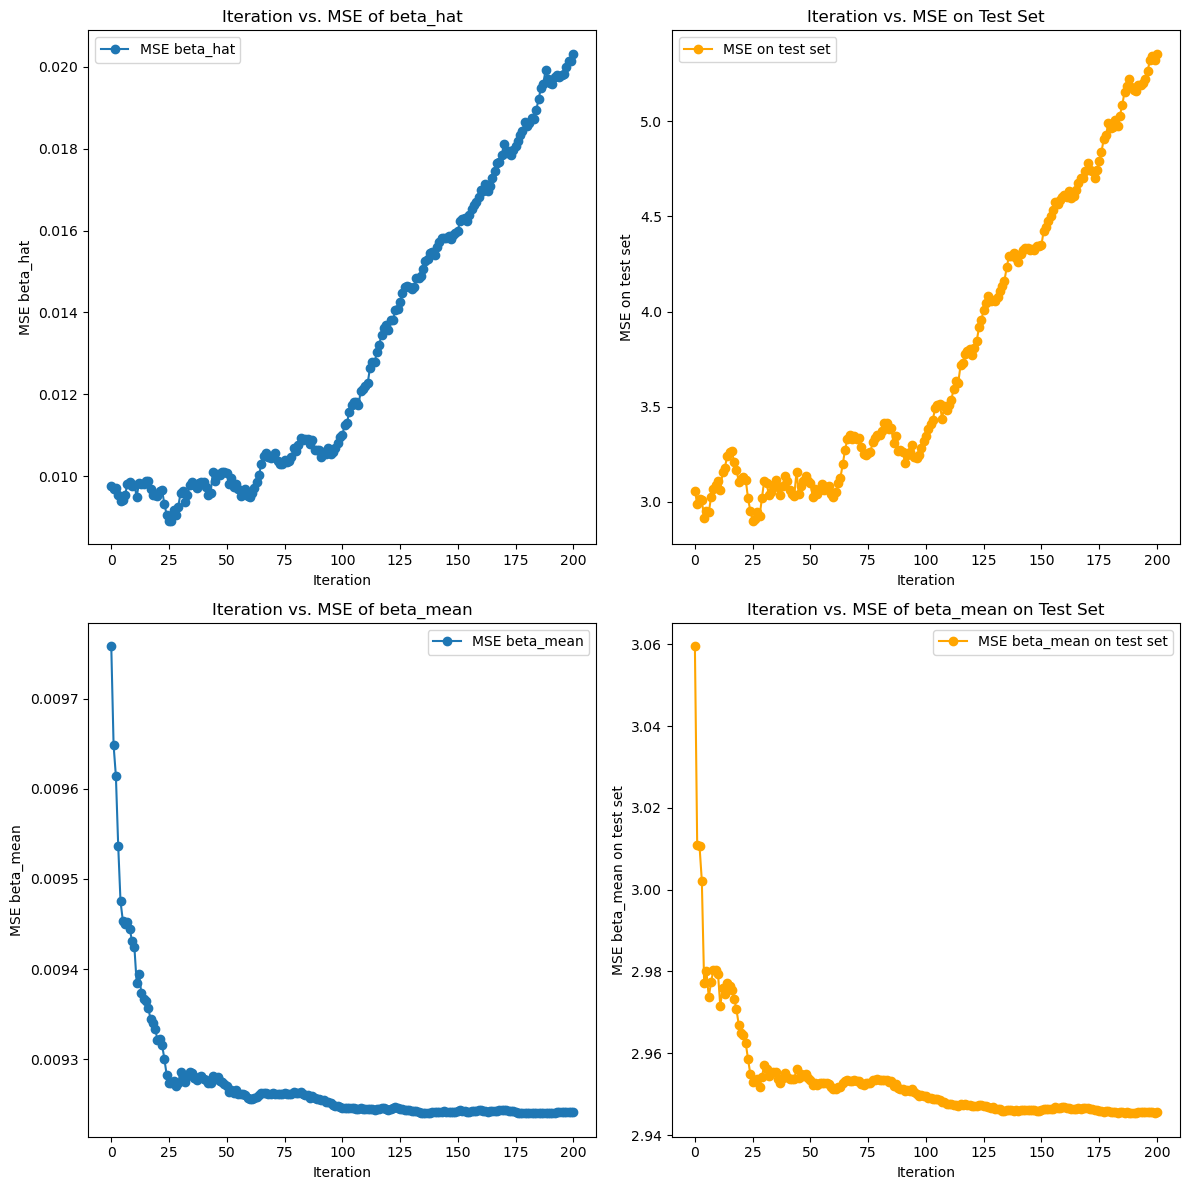

In [5]:
iter = 200
# Calculate residuals and set weights
weights = np.ones(train_size)
beta_history = [beta_hat_orignal]
MSE_history = [MSE_beta_hat_original]
MSE_test_history = [MSE_test_original]
MSE_beta_mean_history = [MSE_beta_hat_original]
MSE_beta_mean_test_history = [MSE_test_original]
beta_hat = beta_hat_orignal
for iteration in range(iter):  # Perform the process twice
    Y_resid = np.abs(Y1 - X1.dot(beta_hat))
    
    # Identify the index of the largest residual
    largest_residual_index = np.argmax(Y_resid * weights)
    
    # Set the weight of the largest residual to zero
    weights[largest_residual_index] = 0
    
    # Compute weighted OLS regression coefficients
    W = np.diag(weights)
    X_transpose_W = X1.T.dot(W)
    X_transpose_W_X = X_transpose_W.dot(X1)
    X_transpose_W_X_inv = np.linalg.inv(X_transpose_W_X)
    X_transpose_W_Y = X_transpose_W.dot(Y1)
    beta_hat = X_transpose_W_X_inv.dot(X_transpose_W_Y)
    beta_history.append(beta_hat)
    MSE_beta_hat = np.mean((beta_hat - true_beta) ** 2)
    MSE_history.append(MSE_beta_hat)
    # Predict on the test set
    Y_test_pred = X_test.dot(beta_hat)

    # Calculate residuals on the test set
    Y_test_resid = Y_test - Y_test_pred

    # Calculate MSE on the test set
    MSE_test = np.mean(Y_test_resid ** 2)
    MSE_test_history.append(MSE_test)

    beta_mean = np.mean(beta_history, axis=0)
    beta_history[-1] = beta_mean#更新最新的beta_hat
    MSE_beta_mean = np.mean((beta_mean - true_beta) ** 2)
    MSE_beta_mean_history.append(MSE_beta_mean)
    Y_beta_mean_test_pred = X_test.dot(beta_mean)
    Y_beta_mean_test_resid = Y_test - Y_beta_mean_test_pred
    MSE_beta_mean_test = np.mean(Y_beta_mean_test_resid ** 2)
    MSE_beta_mean_test_history.append(MSE_beta_mean_test)

# 绘制迭代次数和MSE的关系图
iterations = list(range(iter+1))  # 包含初始值的0次迭代

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(iterations, MSE_history, marker='o', label='MSE beta_hat')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_hat')
plt.title('Iteration vs. MSE of beta_hat')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iterations, MSE_test_history, marker='o', label='MSE on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE on test set')
plt.title('Iteration vs. MSE on Test Set')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iterations, MSE_beta_mean_history, marker='o', label='MSE beta_mean')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean')
plt.title('Iteration vs. MSE of beta_mean')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iterations, MSE_beta_mean_test_history, marker='o', label='MSE beta_mean on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean on test set')
plt.title('Iteration vs. MSE of beta_mean on Test Set')
plt.legend()

plt.tight_layout()
plt.show()


##### gradient descent来更新

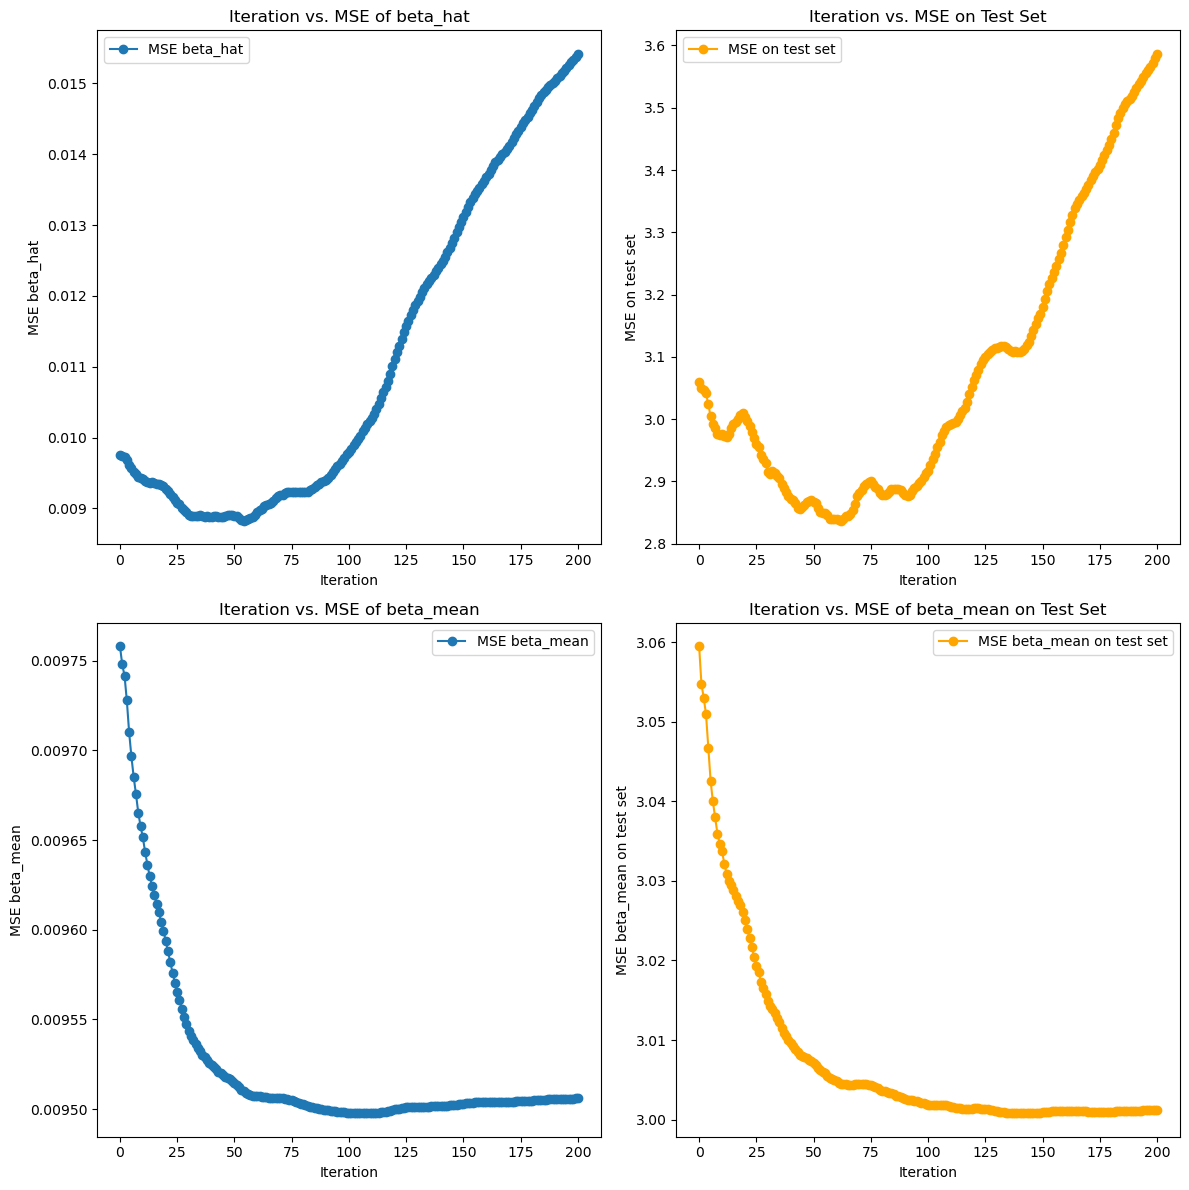

In [6]:
iter = 200
learning_rate = 0.1
# Calculate residuals and set weights
weights = np.ones(train_size)
beta_history = [beta_hat_orignal]
MSE_history = [MSE_beta_hat_original]
MSE_test_history = [MSE_test_original]
MSE_beta_mean_history = [MSE_beta_hat_original]
MSE_beta_mean_test_history = [MSE_test_original]
beta_hat = beta_hat_orignal
for iteration in range(iter):  # Perform the process twice
    Y_resid = np.abs(Y1 - X1.dot(beta_hat))
    
    # Identify the index of the largest residual
    largest_residual_index = np.argmax(Y_resid * weights)
    
    # Set the weight of the largest residual to zero
    weights[largest_residual_index] = 0
    
    # Compute weighted OLS regression coefficients
    weighted_resid = weights * (X1.dot(beta_hat) -Y1)
    gradient = 2 * X1.T.dot(weighted_resid) / len(Y1)
    beta_hat = beta_hat - learning_rate*gradient
    
    beta_history.append(beta_hat)
    MSE_beta_hat = np.mean((beta_hat - true_beta) ** 2)
    MSE_history.append(MSE_beta_hat)
    # Predict on the test set
    Y_test_pred = X_test.dot(beta_hat)

    # Calculate residuals on the test set
    Y_test_resid = Y_test - Y_test_pred

    # Calculate MSE on the test set
    MSE_test = np.mean(Y_test_resid ** 2)
    MSE_test_history.append(MSE_test)

    beta_mean = np.mean(beta_history, axis=0)
    beta_history[-1] = beta_mean#更新最新的beta_hat
    MSE_beta_mean = np.mean((beta_mean - true_beta) ** 2)
    MSE_beta_mean_history.append(MSE_beta_mean)
    Y_beta_mean_test_pred = X_test.dot(beta_mean)
    Y_beta_mean_test_resid = Y_test - Y_beta_mean_test_pred
    MSE_beta_mean_test = np.mean(Y_beta_mean_test_resid ** 2)
    MSE_beta_mean_test_history.append(MSE_beta_mean_test)

# 绘制迭代次数和MSE的关系图
iterations = list(range(iter+1))  # 包含初始值的0次迭代

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(iterations, MSE_history, marker='o', label='MSE beta_hat')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_hat')
plt.title('Iteration vs. MSE of beta_hat')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iterations, MSE_test_history, marker='o', label='MSE on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE on test set')
plt.title('Iteration vs. MSE on Test Set')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iterations, MSE_beta_mean_history, marker='o', label='MSE beta_mean')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean')
plt.title('Iteration vs. MSE of beta_mean')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iterations, MSE_beta_mean_test_history, marker='o', label='MSE beta_mean on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean on test set')
plt.title('Iteration vs. MSE of beta_mean on Test Set')
plt.legend()

plt.tight_layout()
plt.show()


#### 使用beta_mean来进行下一步的筛选

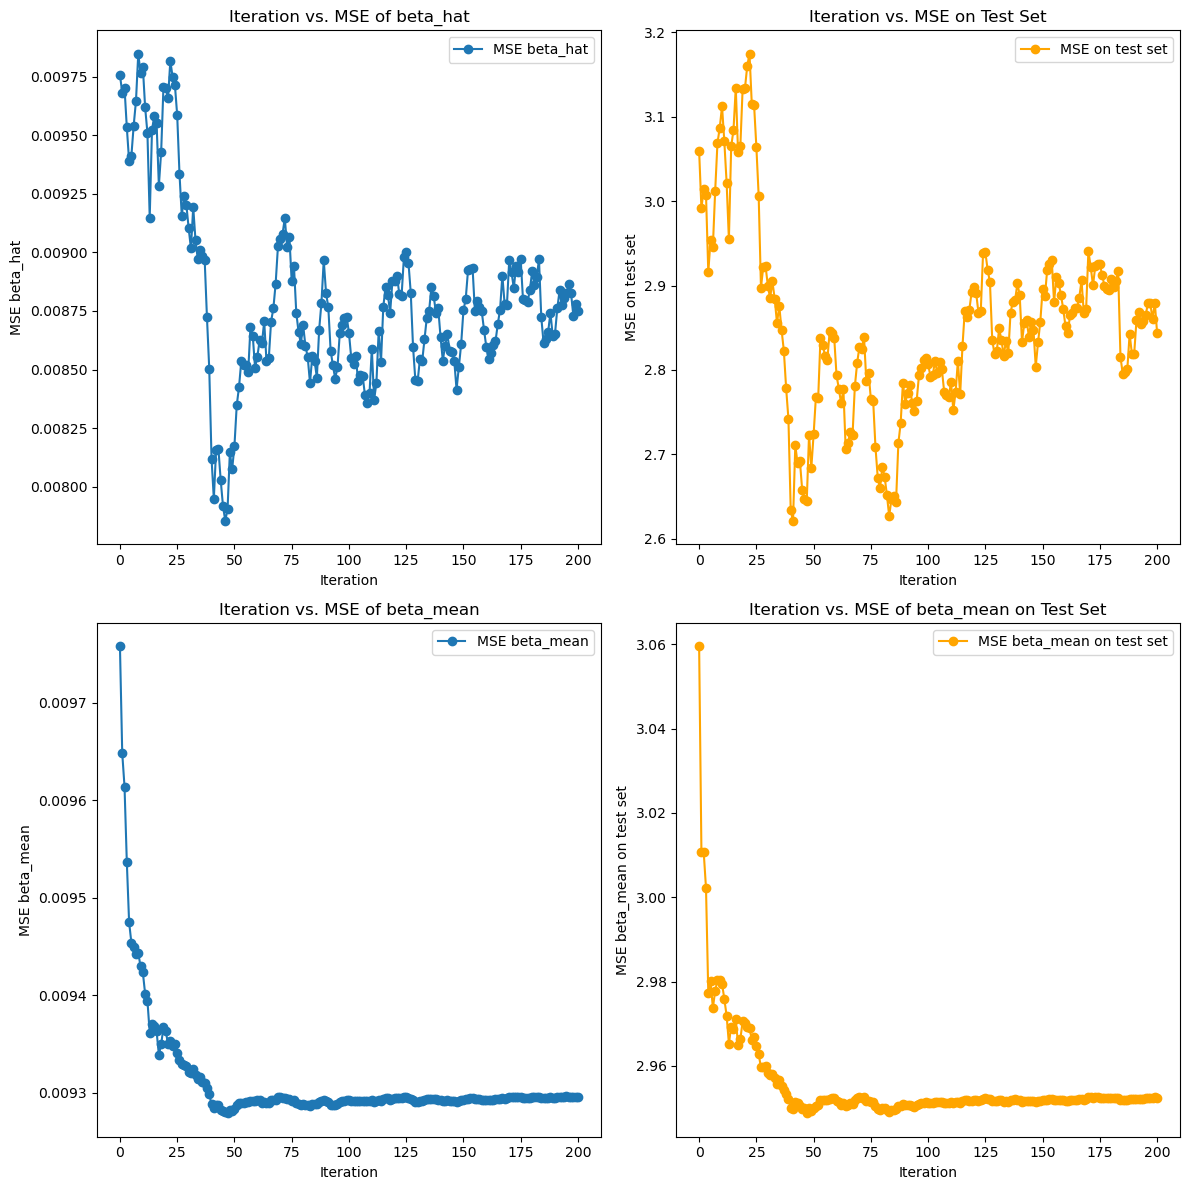

In [7]:
iter = 200
# Calculate residuals and set weights
weights = np.ones(train_size)
beta_history = [beta_hat_orignal]
MSE_history = [MSE_beta_hat_original]
MSE_test_history = [MSE_test_original]
MSE_beta_mean_history = [MSE_beta_hat_original]
MSE_beta_mean_test_history = [MSE_test_original]
beta_hat = beta_hat_orignal
beta_mean = beta_hat_orignal
for iteration in range(iter):  # Perform the process twice
    Y_resid = np.abs(Y1 - X1.dot(beta_mean))
    
    # Identify the index of the largest residual
    largest_residual_index = np.argmax(Y_resid * weights)
    
    # Set the weight of the largest residual to zero
    weights[largest_residual_index] = 0
    
    # Compute weighted OLS regression coefficients
    W = np.diag(weights)
    X_transpose_W = X1.T.dot(W)
    X_transpose_W_X = X_transpose_W.dot(X1)
    X_transpose_W_X_inv = np.linalg.inv(X_transpose_W_X)
    X_transpose_W_Y = X_transpose_W.dot(Y1)
    beta_hat = X_transpose_W_X_inv.dot(X_transpose_W_Y)
    beta_history.append(beta_hat)
    MSE_beta_hat = np.mean((beta_hat - true_beta) ** 2)
    MSE_history.append(MSE_beta_hat)

    # Predict on the test set
    Y_test_pred = X_test.dot(beta_hat)

    # Calculate residuals on the test set
    Y_test_resid = Y_test - Y_test_pred

    # Calculate MSE on the test set
    MSE_test = np.mean(Y_test_resid ** 2)
    MSE_test_history.append(MSE_test)

    beta_mean = np.mean(beta_history, axis=0)
    beta_history[-1] = beta_mean#更新最新的beta_hat
    MSE_beta_mean = np.mean((beta_mean - true_beta) ** 2)
    MSE_beta_mean_history.append(MSE_beta_mean)
    Y_beta_mean_test_pred = X_test.dot(beta_mean)
    Y_beta_mean_test_resid = Y_test - Y_beta_mean_test_pred
    MSE_beta_mean_test = np.mean(Y_beta_mean_test_resid ** 2)
    MSE_beta_mean_test_history.append(MSE_beta_mean_test)

# 绘制迭代次数和MSE的关系图
iterations = list(range(iter+1))  # 包含初始值的0次迭代

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(iterations, MSE_history, marker='o', label='MSE beta_hat')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_hat')
plt.title('Iteration vs. MSE of beta_hat')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iterations, MSE_test_history, marker='o', label='MSE on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE on test set')
plt.title('Iteration vs. MSE on Test Set')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iterations, MSE_beta_mean_history, marker='o', label='MSE beta_mean')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean')
plt.title('Iteration vs. MSE of beta_mean')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iterations, MSE_beta_mean_test_history, marker='o', label='MSE beta_mean on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean on test set')
plt.title('Iteration vs. MSE of beta_mean on Test Set')
plt.legend()

plt.tight_layout()
plt.show()


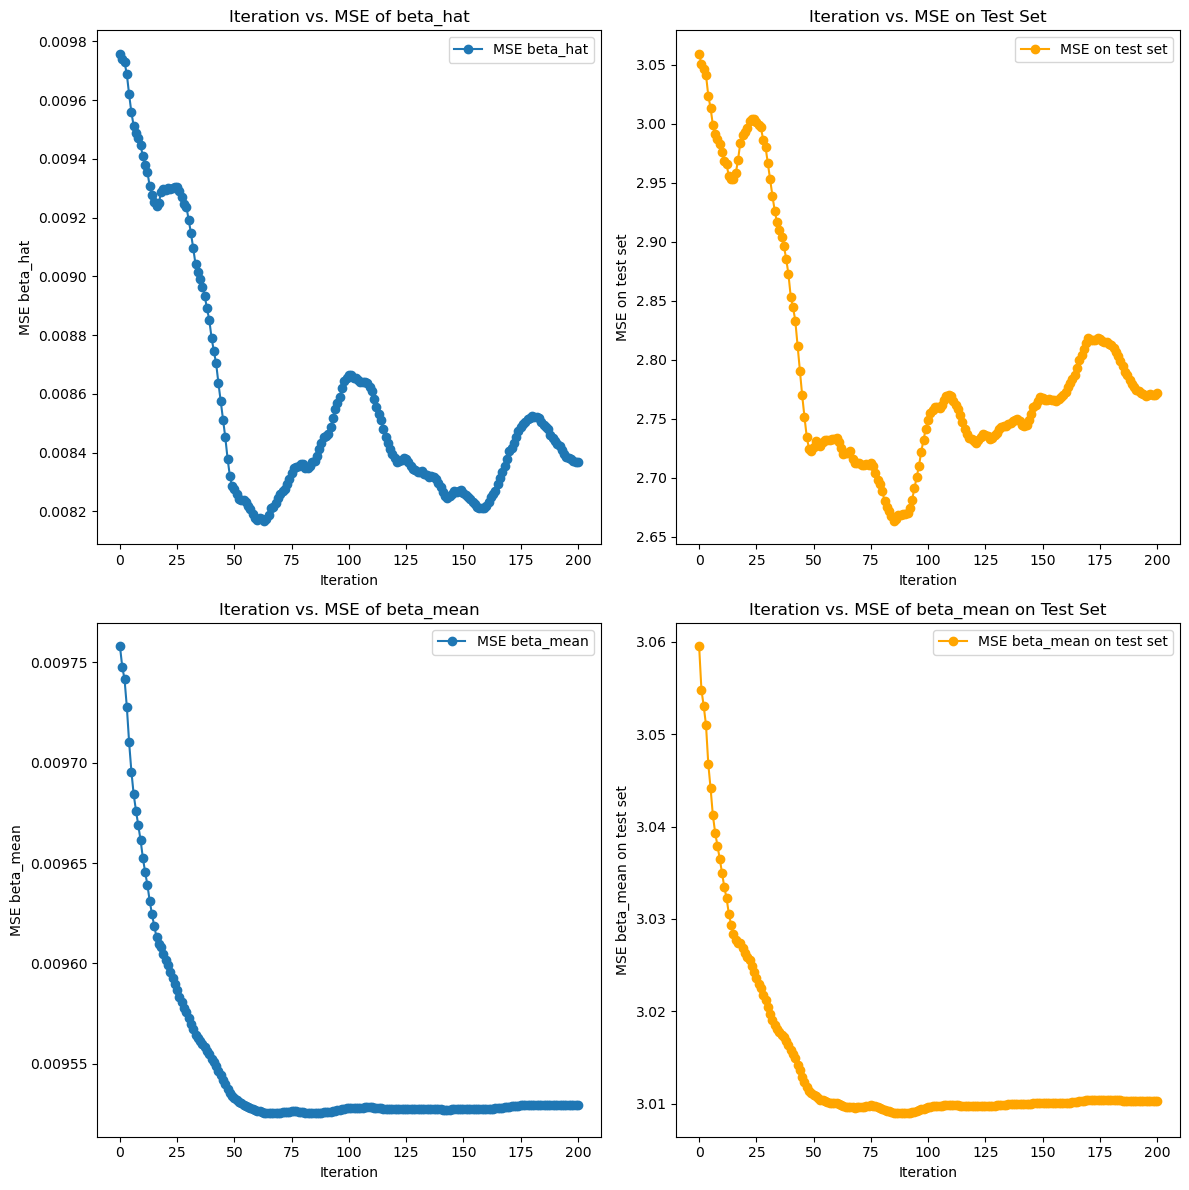

In [8]:
iter = 200
# Calculate residuals and set weights
weights = np.ones(train_size)
beta_history = [beta_hat_orignal]
MSE_history = [MSE_beta_hat_original]
MSE_test_history = [MSE_test_original]
MSE_beta_mean_history = [MSE_beta_hat_original]
MSE_beta_mean_test_history = [MSE_test_original]
beta_hat = beta_hat_orignal
beta_mean = beta_hat_orignal
for iteration in range(iter):  # Perform the process twice
    Y_resid = np.abs(Y1 - X1.dot(beta_mean))
    
    # Identify the index of the largest residual
    largest_residual_index = np.argmax(Y_resid * weights)
    
    # Set the weight of the largest residual to zero
    weights[largest_residual_index] = 0

    # Compute weighted OLS regression coefficients
    weighted_resid = weights * (X1.dot(beta_hat) -Y1)
    gradient = 2 * X1.T.dot(weighted_resid) / len(Y1)
    beta_hat = beta_hat - learning_rate*gradient

    beta_history.append(beta_hat)
    MSE_beta_hat = np.mean((beta_hat - true_beta) ** 2)
    MSE_history.append(MSE_beta_hat)

    # Predict on the test set
    Y_test_pred = X_test.dot(beta_hat)

    # Calculate residuals on the test set
    Y_test_resid = Y_test - Y_test_pred

    # Calculate MSE on the test set
    MSE_test = np.mean(Y_test_resid ** 2)
    MSE_test_history.append(MSE_test)

    beta_mean = np.mean(beta_history, axis=0)
    beta_history[-1] = beta_mean#更新最新的beta_hat
    MSE_beta_mean = np.mean((beta_mean - true_beta) ** 2)
    MSE_beta_mean_history.append(MSE_beta_mean)
    Y_beta_mean_test_pred = X_test.dot(beta_mean)
    Y_beta_mean_test_resid = Y_test - Y_beta_mean_test_pred
    MSE_beta_mean_test = np.mean(Y_beta_mean_test_resid ** 2)
    MSE_beta_mean_test_history.append(MSE_beta_mean_test)

# 绘制迭代次数和MSE的关系图
iterations = list(range(iter+1))  # 包含初始值的0次迭代

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(iterations, MSE_history, marker='o', label='MSE beta_hat')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_hat')
plt.title('Iteration vs. MSE of beta_hat')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iterations, MSE_test_history, marker='o', label='MSE on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE on test set')
plt.title('Iteration vs. MSE on Test Set')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iterations, MSE_beta_mean_history, marker='o', label='MSE beta_mean')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean')
plt.title('Iteration vs. MSE of beta_mean')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iterations, MSE_beta_mean_test_history, marker='o', label='MSE beta_mean on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean on test set')
plt.title('Iteration vs. MSE of beta_mean on Test Set')
plt.legend()

plt.tight_layout()
plt.show()


### 一次删k个点
#### 每次进行平均时候不更新$\beta$

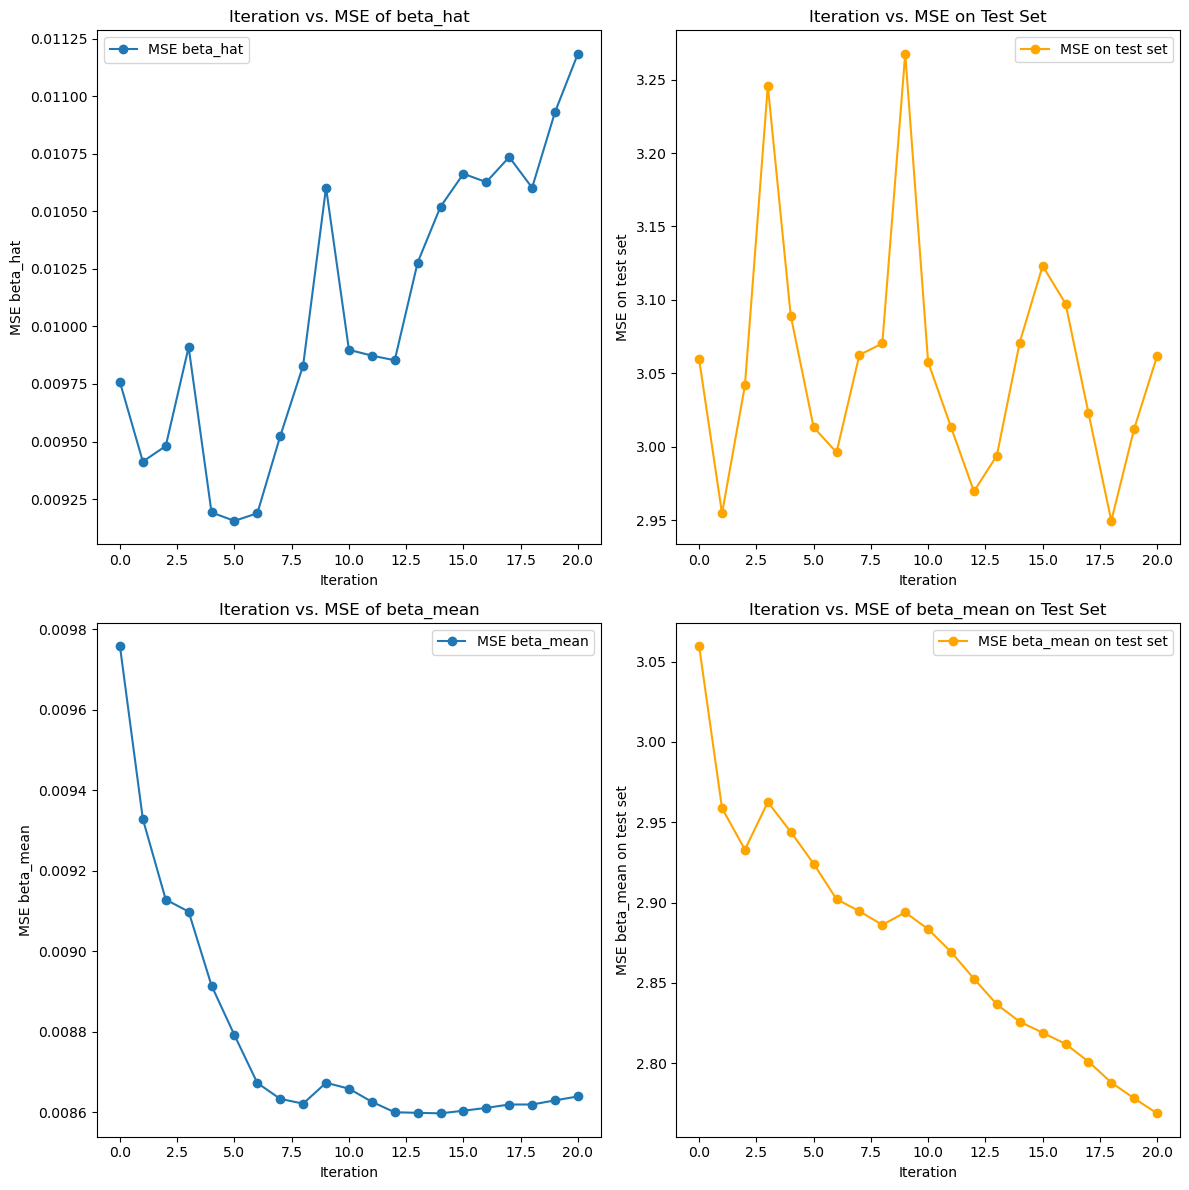

In [9]:
iter = 20
k = 5
# Calculate residuals and set weights
weights = np.ones(train_size)
beta_history = [beta_hat_orignal]
MSE_history = [MSE_beta_hat_original]
MSE_test_history = [MSE_test_original]
MSE_beta_mean_history = [MSE_beta_hat_original]
MSE_beta_mean_test_history = [MSE_test_original]
beta_hat = beta_hat_orignal

# 迭代
for iteration in range(iter):
    Y_resid = np.abs(Y1 - X1.dot(beta_hat))
    
    # 标识最大残差的索引
    largest_residual_indices = np.argsort(Y_resid * weights)[-k:]  # 取最大的两个残差索引
    
    # 设置最大残差的权重为0
    weights[largest_residual_indices] = 0
    
    # 计算加权最小二乘法的回归系数
    W = np.diag(weights)
    X_transpose_W = X1.T.dot(W)
    X_transpose_W_X = X_transpose_W.dot(X1)
    X_transpose_W_X_inv = np.linalg.inv(X_transpose_W_X)
    X_transpose_W_Y = X_transpose_W.dot(Y1)
    beta_hat = X_transpose_W_X_inv.dot(X_transpose_W_Y)
    
    # 记录系数和MSE
    beta_history.append(beta_hat)
    MSE_beta_hat = np.mean((beta_hat - true_beta) ** 2)
    MSE_history.append(MSE_beta_hat)
    
    # 在测试集上预测
    Y_test_pred = X_test.dot(beta_hat)
    Y_test_resid = Y_test - Y_test_pred
    MSE_test = np.mean(Y_test_resid ** 2)
    MSE_test_history.append(MSE_test)

    beta_mean = np.mean(beta_history, axis=0)
    MSE_beta_mean = np.mean((beta_mean - true_beta) ** 2)
    MSE_beta_mean_history.append(MSE_beta_mean)
    Y_beta_mean_test_pred = X_test.dot(beta_mean)
    Y_beta_mean_test_resid = Y_test - Y_beta_mean_test_pred
    MSE_beta_mean_test = np.mean(Y_beta_mean_test_resid ** 2)
    MSE_beta_mean_test_history.append(MSE_beta_mean_test)

# 绘制迭代次数和MSE的关系图
iterations = list(range(iter+1))  # 包含初始值的0次迭代

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(iterations, MSE_history, marker='o', label='MSE beta_hat')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_hat')
plt.title('Iteration vs. MSE of beta_hat')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iterations, MSE_test_history, marker='o', label='MSE on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE on test set')
plt.title('Iteration vs. MSE on Test Set')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iterations, MSE_beta_mean_history, marker='o', label='MSE beta_mean')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean')
plt.title('Iteration vs. MSE of beta_mean')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iterations, MSE_beta_mean_test_history, marker='o', label='MSE beta_mean on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean on test set')
plt.title('Iteration vs. MSE of beta_mean on Test Set')
plt.legend()

plt.tight_layout()
plt.show()

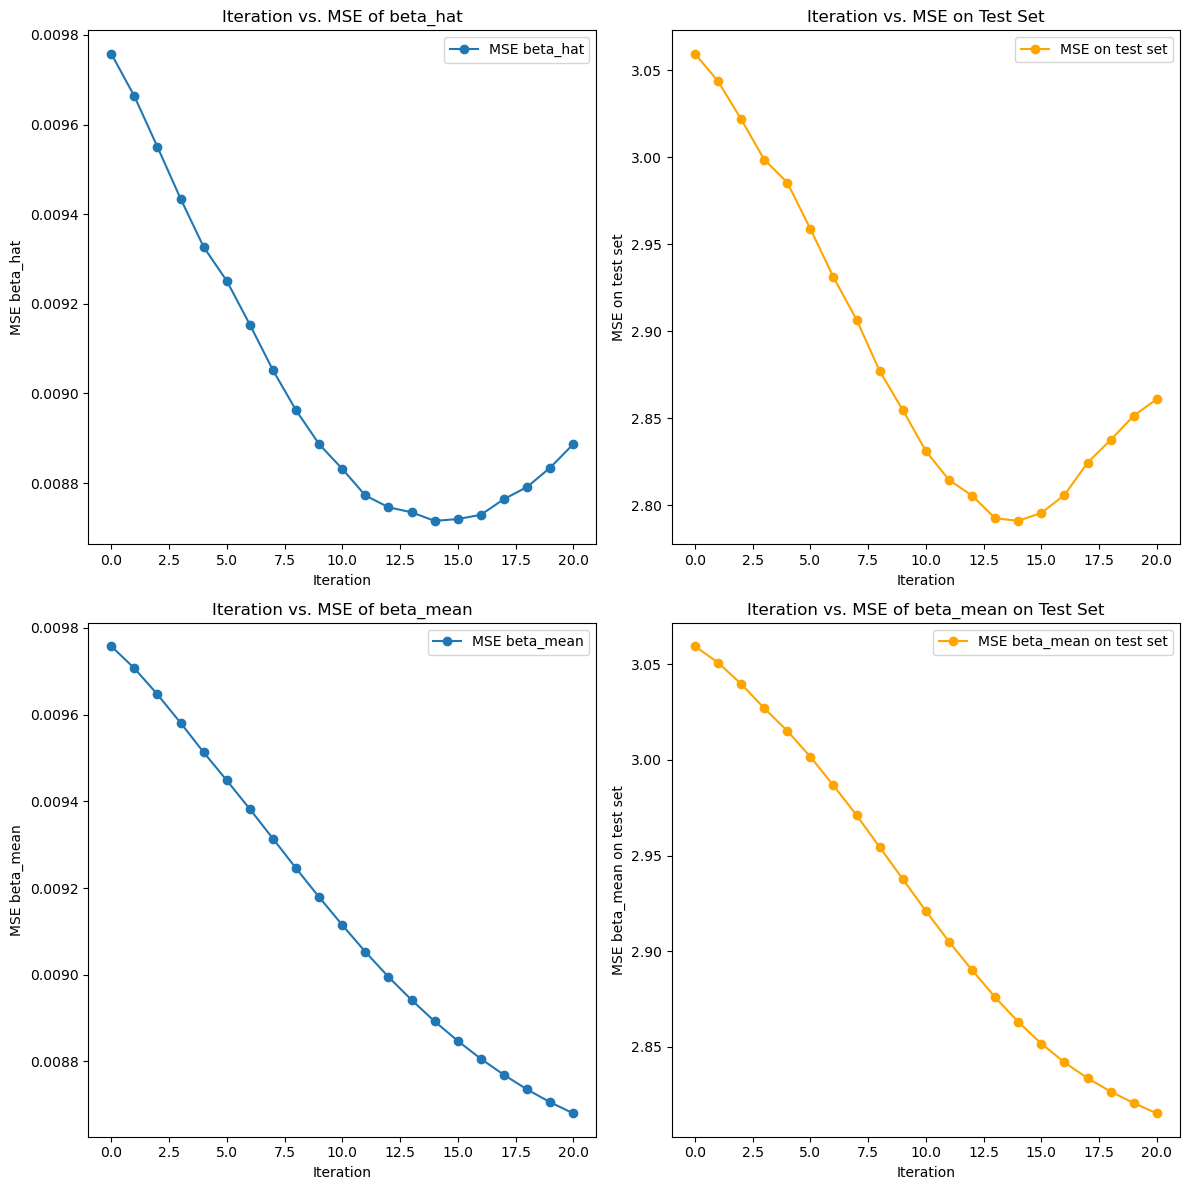

In [10]:
iter = 20
k = 5
# Calculate residuals and set weights
weights = np.ones(train_size)
beta_history = [beta_hat_orignal]
MSE_history = [MSE_beta_hat_original]
MSE_test_history = [MSE_test_original]
MSE_beta_mean_history = [MSE_beta_hat_original]
MSE_beta_mean_test_history = [MSE_test_original]
beta_hat = beta_hat_orignal

# 迭代
for iteration in range(iter):
    Y_resid = np.abs(Y1 - X1.dot(beta_hat))
    # 标识最大残差的索引
    largest_residual_indices = np.argsort(Y_resid * weights)[-k:]  # 取最大的两个残差索引
    
    # 设置最大残差的权重为0
    weights[largest_residual_indices] = 0
    
    # 计算加权最小二乘法的回归系数
    weighted_resid = weights * (X1.dot(beta_hat) -Y1)
    gradient = 2 * X1.T.dot(weighted_resid) / len(Y1)
    beta_hat = beta_hat - 0.1*gradient
    
    # 记录系数和MSE
    beta_history.append(beta_hat)
    MSE_beta_hat = np.mean((beta_hat - true_beta) ** 2)
    MSE_history.append(MSE_beta_hat)
    
    # 在测试集上预测
    Y_test_pred = X_test.dot(beta_hat)
    Y_test_resid = Y_test - Y_test_pred
    MSE_test = np.mean(Y_test_resid ** 2)
    MSE_test_history.append(MSE_test)

    beta_mean = np.mean(beta_history, axis=0)
    MSE_beta_mean = np.mean((beta_mean - true_beta) ** 2)
    MSE_beta_mean_history.append(MSE_beta_mean)
    Y_beta_mean_test_pred = X_test.dot(beta_mean)
    Y_beta_mean_test_resid = Y_test - Y_beta_mean_test_pred
    MSE_beta_mean_test = np.mean(Y_beta_mean_test_resid ** 2)
    MSE_beta_mean_test_history.append(MSE_beta_mean_test)

# 绘制迭代次数和MSE的关系图
iterations = list(range(iter+1))  # 包含初始值的0次迭代

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(iterations, MSE_history, marker='o', label='MSE beta_hat')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_hat')
plt.title('Iteration vs. MSE of beta_hat')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iterations, MSE_test_history, marker='o', label='MSE on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE on test set')
plt.title('Iteration vs. MSE on Test Set')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iterations, MSE_beta_mean_history, marker='o', label='MSE beta_mean')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean')
plt.title('Iteration vs. MSE of beta_mean')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iterations, MSE_beta_mean_test_history, marker='o', label='MSE beta_mean on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean on test set')
plt.title('Iteration vs. MSE of beta_mean on Test Set')
plt.legend()

plt.tight_layout()
plt.show()

#### 每次进行平均时候更新$\beta$

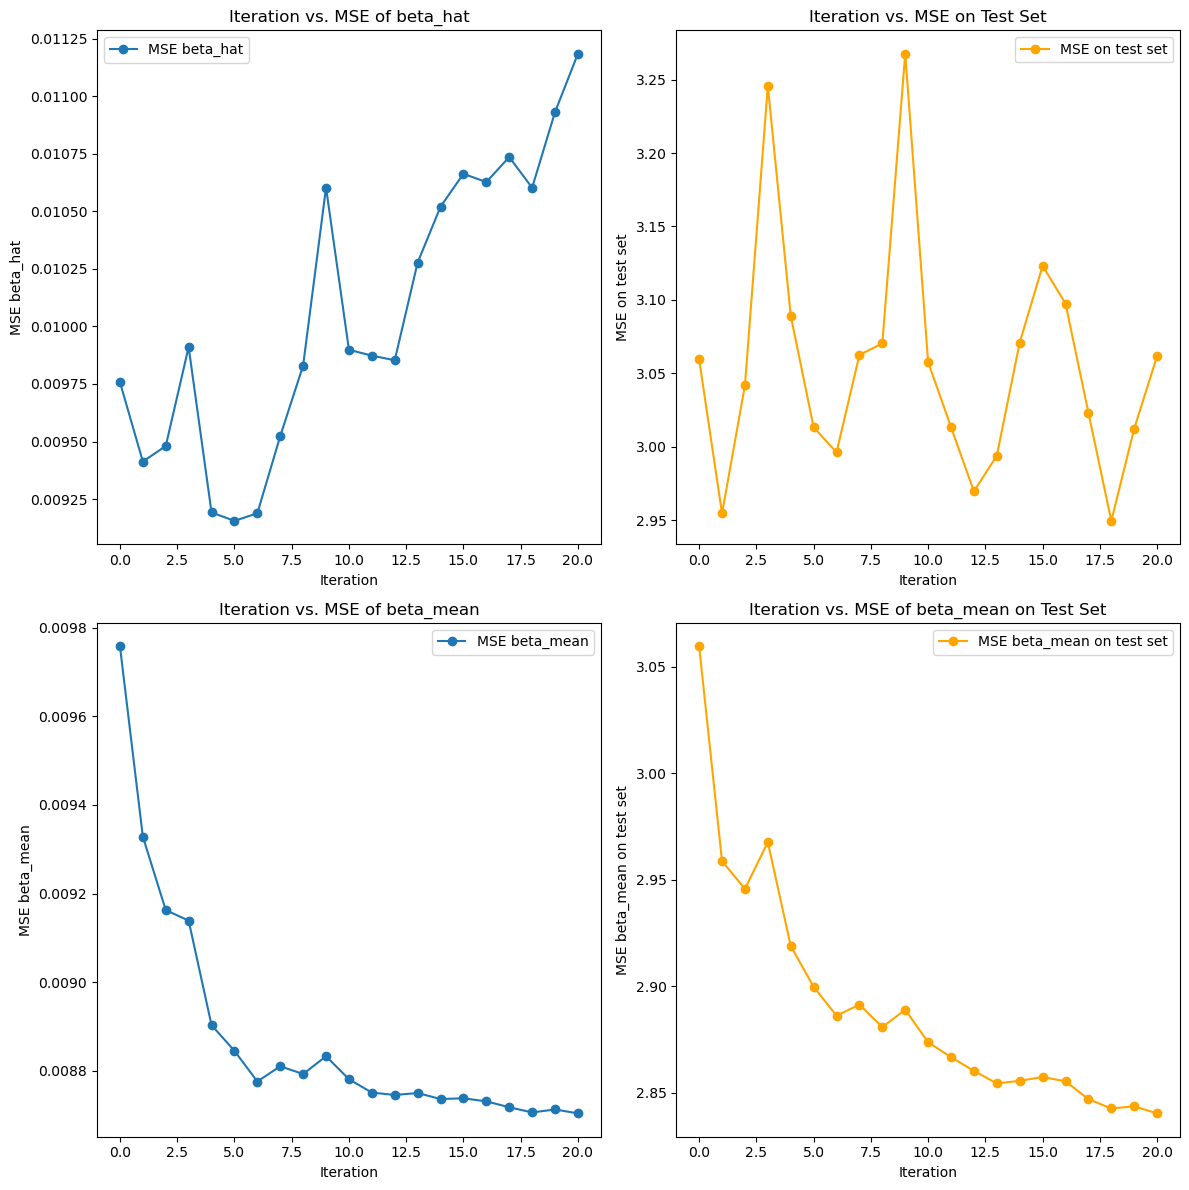

In [11]:
iter = 20
k = 5
# Calculate residuals and set weights
weights = np.ones(train_size)
beta_history = [beta_hat_orignal]
MSE_history = [MSE_beta_hat_original]
MSE_test_history = [MSE_test_original]
MSE_beta_mean_history = [MSE_beta_hat_original]
MSE_beta_mean_test_history = [MSE_test_original]
beta_hat = beta_hat_orignal

# 迭代
for iteration in range(iter):
    Y_resid = np.abs(Y1 - X1.dot(beta_hat))
    
    # 标识最大残差的索引
    largest_residual_indices = np.argsort(Y_resid * weights)[-k:]  # 取最大的两个残差索引
    
    # 设置最大残差的权重为0
    weights[largest_residual_indices] = 0
    
    # 计算加权最小二乘法的回归系数
    W = np.diag(weights)
    X_transpose_W = X1.T.dot(W)
    X_transpose_W_X = X_transpose_W.dot(X1)
    X_transpose_W_X_inv = np.linalg.inv(X_transpose_W_X)
    X_transpose_W_Y = X_transpose_W.dot(Y1)
    beta_hat = X_transpose_W_X_inv.dot(X_transpose_W_Y)
    
    # 记录系数和MSE
    beta_history.append(beta_hat)
    MSE_beta_hat = np.mean((beta_hat - true_beta) ** 2)
    MSE_history.append(MSE_beta_hat)
    
    # 在测试集上预测
    Y_test_pred = X_test.dot(beta_hat)
    Y_test_resid = Y_test - Y_test_pred
    MSE_test = np.mean(Y_test_resid ** 2)
    MSE_test_history.append(MSE_test)

    beta_mean = np.mean(beta_history, axis=0)
    beta_history[-1] = beta_mean#更新最新的beta_hat
    MSE_beta_mean = np.mean((beta_mean - true_beta) ** 2)
    MSE_beta_mean_history.append(MSE_beta_mean)
    Y_beta_mean_test_pred = X_test.dot(beta_mean)
    Y_beta_mean_test_resid = Y_test - Y_beta_mean_test_pred
    MSE_beta_mean_test = np.mean(Y_beta_mean_test_resid ** 2)
    MSE_beta_mean_test_history.append(MSE_beta_mean_test)

# 绘制迭代次数和MSE的关系图
iterations = list(range(iter+1))  # 包含初始值的0次迭代

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(iterations, MSE_history, marker='o', label='MSE beta_hat')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_hat')
plt.title('Iteration vs. MSE of beta_hat')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iterations, MSE_test_history, marker='o', label='MSE on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE on test set')
plt.title('Iteration vs. MSE on Test Set')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iterations, MSE_beta_mean_history, marker='o', label='MSE beta_mean')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean')
plt.title('Iteration vs. MSE of beta_mean')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iterations, MSE_beta_mean_test_history, marker='o', label='MSE beta_mean on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean on test set')
plt.title('Iteration vs. MSE of beta_mean on Test Set')
plt.legend()

plt.tight_layout()
plt.show()

#### 平均时候只取后面两个

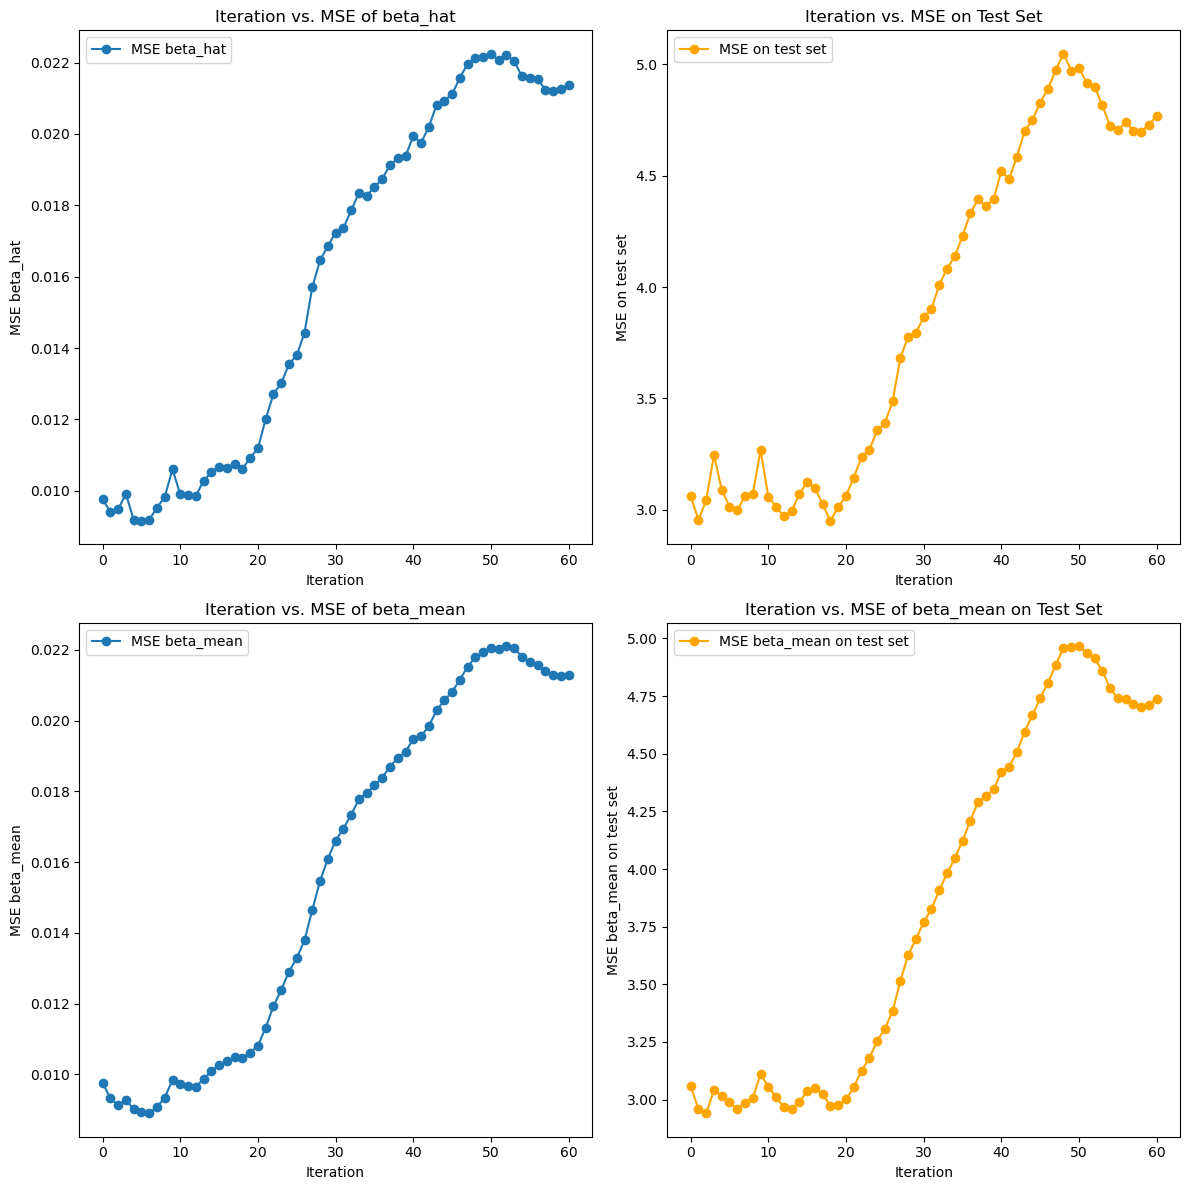

In [12]:
iter = 60
k = 5
# Calculate residuals and set weights
weights = np.ones(train_size)
beta_history = [beta_hat_orignal]
MSE_history = [MSE_beta_hat_original]
MSE_test_history = [MSE_test_original]
MSE_beta_mean_history = [MSE_beta_hat_original]
MSE_beta_mean_test_history = [MSE_test_original]
beta_hat = beta_hat_orignal

# 迭代
for iteration in range(iter):
    Y_resid = np.abs(Y1 - X1.dot(beta_hat))
    
    # 标识最大残差的索引
    largest_residual_indices = np.argsort(Y_resid * weights)[-k:]  # 取最大的两个残差索引
    
    # 设置最大残差的权重为0
    weights[largest_residual_indices] = 0
    
    # 计算加权最小二乘法的回归系数
    W = np.diag(weights)
    X_transpose_W = X1.T.dot(W)
    X_transpose_W_X = X_transpose_W.dot(X1)
    X_transpose_W_X_inv = np.linalg.inv(X_transpose_W_X)
    X_transpose_W_Y = X_transpose_W.dot(Y1)
    beta_hat = X_transpose_W_X_inv.dot(X_transpose_W_Y)
    
    # 记录系数和MSE
    beta_history.append(beta_hat)
    MSE_beta_hat = np.mean((beta_hat - true_beta) ** 2)
    MSE_history.append(MSE_beta_hat)
    
    # 在测试集上预测
    Y_test_pred = X_test.dot(beta_hat)
    Y_test_resid = Y_test - Y_test_pred
    MSE_test = np.mean(Y_test_resid ** 2)
    MSE_test_history.append(MSE_test)

    beta_mean_last2 = np.mean(beta_history[-2:], axis=0)
    beta_history[-1] = beta_mean_last2#更新最新的beta_hat
    MSE_beta_mean = np.mean((beta_mean_last2 - true_beta) ** 2)
    MSE_beta_mean_history.append(MSE_beta_mean)
    Y_beta_mean_test_pred = X_test.dot(beta_mean_last2)
    Y_beta_mean_test_resid = Y_test - Y_beta_mean_test_pred
    MSE_beta_mean_test = np.mean(Y_beta_mean_test_resid ** 2)
    MSE_beta_mean_test_history.append(MSE_beta_mean_test)

# 绘制迭代次数和MSE的关系图
iterations = list(range(iter+1))  # 包含初始值的0次迭代

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(iterations, MSE_history, marker='o', label='MSE beta_hat')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_hat')
plt.title('Iteration vs. MSE of beta_hat')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iterations, MSE_test_history, marker='o', label='MSE on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE on test set')
plt.title('Iteration vs. MSE on Test Set')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iterations, MSE_beta_mean_history, marker='o', label='MSE beta_mean')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean')
plt.title('Iteration vs. MSE of beta_mean')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iterations, MSE_beta_mean_test_history, marker='o', label='MSE beta_mean on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean on test set')
plt.title('Iteration vs. MSE of beta_mean on Test Set')
plt.legend()

plt.tight_layout()
plt.show()

## 随机删减
### 每次取前面5个，随机删一个，重复五次

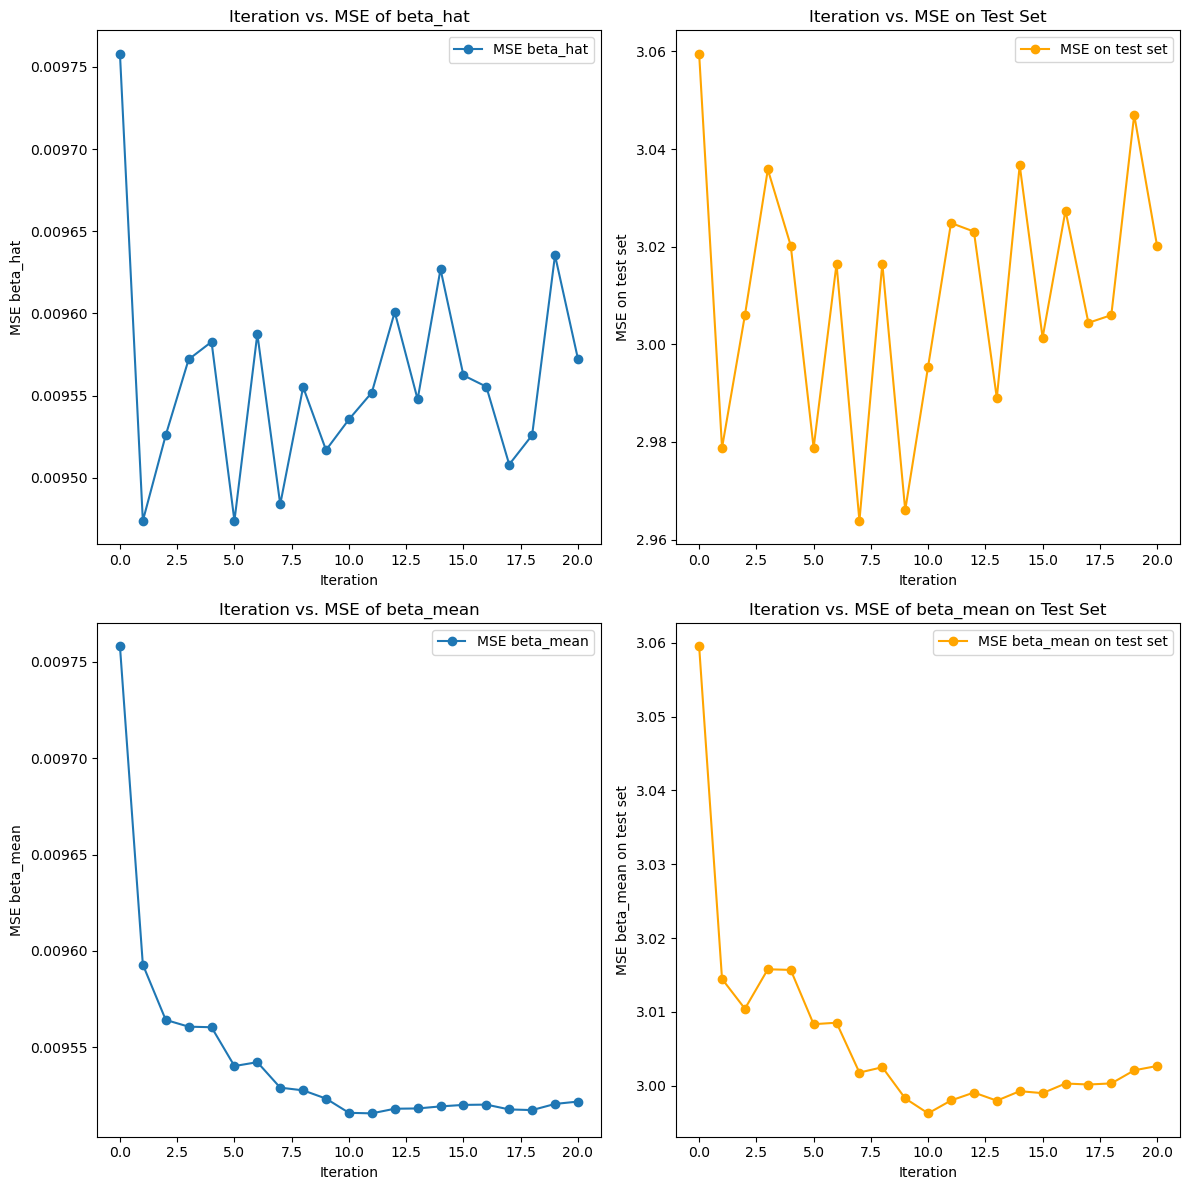

In [13]:
iter = 20
n = 5 # 选择前n个最大残差
k = 1 # 每次随机删除的点数
m = 5  # 重复次数
# Calculate residuals and set weights
weights = np.ones(train_size)
beta_history = [beta_hat_orignal]
beta_hat = beta_hat_orignal
MSE_history = [MSE_beta_hat_original]
MSE_test_history = [MSE_test_original]
MSE_beta_mean_history = [MSE_beta_hat_original]
MSE_beta_mean_test_history = [MSE_test_original]

# 迭代
for iteration in range(iter):
    Y_resid = np.abs(Y1 - X1.dot(beta_hat))
    
    # 标识最大残差的索引
    largest_residual_indices = np.argsort(Y_resid * weights)[-n:]  # 取最大的两个残差索引
    
    betas = []
    for _ in range(m):  # 多次重复取平均
        weights_temp = weights.copy()
        delete_indices = np.random.choice(largest_residual_indices, k, replace=False)
        weights_temp[delete_indices] = 0
        
        # 计算加权最小二乘法的回归系数
        W = np.diag(weights_temp)
        X_transpose_W = X1.T.dot(W)
        X_transpose_W_X = X_transpose_W.dot(X1)
        X_transpose_W_X_inv = np.linalg.inv(X_transpose_W_X)
        X_transpose_W_Y = X_transpose_W.dot(Y1)
        beta_hat_temp = X_transpose_W_X_inv.dot(X_transpose_W_Y)
        betas.append(beta_hat_temp)
    
    # 当前迭代的beta取平均
    beta_hat = np.mean(betas, axis=0)
    
    # 记录系数和MSE
    beta_history.append(beta_hat)
    MSE_beta_hat = np.mean((beta_hat - true_beta) ** 2)
    MSE_history.append(MSE_beta_hat)
    
    # 在测试集上预测
    Y_test_pred = X_test.dot(beta_hat)
    Y_test_resid = Y_test - Y_test_pred
    MSE_test = np.mean(Y_test_resid ** 2)
    MSE_test_history.append(MSE_test)

    beta_mean = np.mean(beta_history, axis=0)
    MSE_beta_mean = np.mean((beta_mean - true_beta) ** 2)
    MSE_beta_mean_history.append(MSE_beta_mean)
    Y_beta_mean_test_pred = X_test.dot(beta_mean)
    Y_beta_mean_test_resid = Y_test - Y_beta_mean_test_pred
    MSE_beta_mean_test = np.mean(Y_beta_mean_test_resid ** 2)
    MSE_beta_mean_test_history.append(MSE_beta_mean_test)

# 绘制迭代次数和MSE的关系图
iterations = list(range(iter+1))  # 包含初始值的0次迭代

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(iterations, MSE_history, marker='o', label='MSE beta_hat')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_hat')
plt.title('Iteration vs. MSE of beta_hat')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iterations, MSE_test_history, marker='o', label='MSE on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE on test set')
plt.title('Iteration vs. MSE on Test Set')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iterations, MSE_beta_mean_history, marker='o', label='MSE beta_mean')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean')
plt.title('Iteration vs. MSE of beta_mean')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iterations, MSE_beta_mean_test_history, marker='o', label='MSE beta_mean on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean on test set')
plt.title('Iteration vs. MSE of beta_mean on Test Set')
plt.legend()

plt.tight_layout()
plt.show()

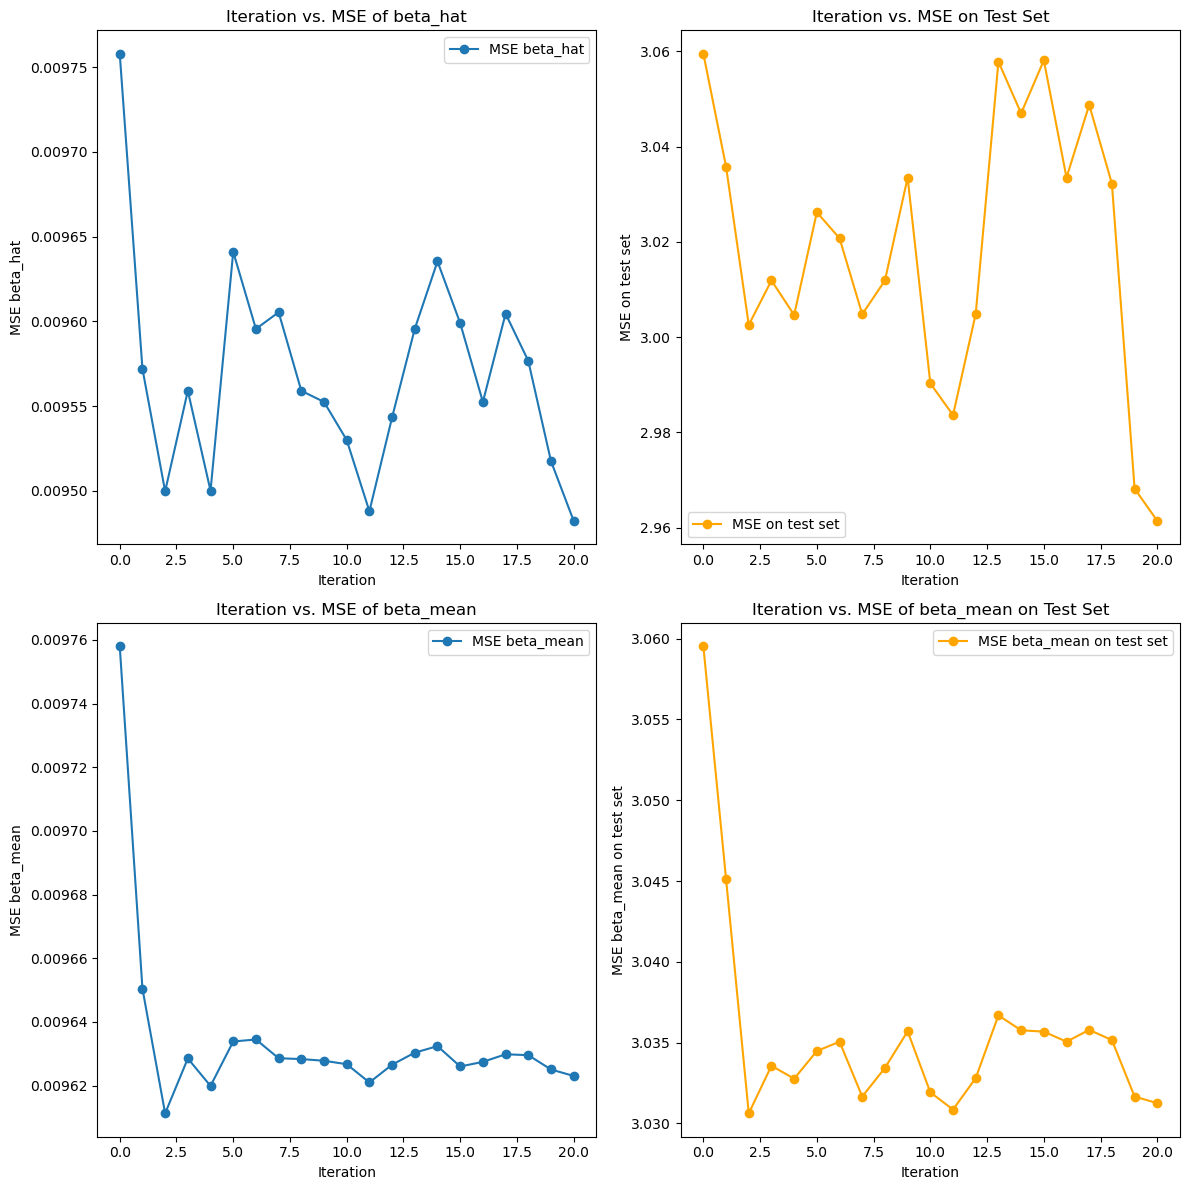

In [14]:
iter = 20
n = 5 # 选择前n个最大残差
k = 1 # 每次随机删除的点数
m = 5  # 重复次数
# Calculate residuals and set weights
weights = np.ones(train_size)
beta_history = [beta_hat_orignal]
beta_hat = beta_hat_orignal
MSE_history = [MSE_beta_hat_original]
MSE_test_history = [MSE_test_original]
MSE_beta_mean_history = [MSE_beta_hat_original]
MSE_beta_mean_test_history = [MSE_test_original]

# 迭代
for iteration in range(iter):
    Y_resid = np.abs(Y1 - X1.dot(beta_hat))
    
    # 标识最大残差的索引
    largest_residual_indices = np.argsort(Y_resid * weights)[-n:]  # 取最大的两个残差索引
    
    betas = []
    for _ in range(m):  # 多次重复取平均
        weights_temp = weights.copy()
        delete_indices = np.random.choice(largest_residual_indices, k, replace=False)
        weights_temp[delete_indices] = 0
        
        # 计算加权最小二乘法的回归系数
        W = np.diag(weights_temp)
        X_transpose_W = X1.T.dot(W)
        X_transpose_W_X = X_transpose_W.dot(X1)
        X_transpose_W_X_inv = np.linalg.inv(X_transpose_W_X)
        X_transpose_W_Y = X_transpose_W.dot(Y1)
        beta_hat_temp = X_transpose_W_X_inv.dot(X_transpose_W_Y)
        betas.append(beta_hat_temp)
    
    # 当前迭代的beta取平均
    beta_hat = np.mean(betas, axis=0)
    
    # 记录系数和MSE
    beta_history.append(beta_hat)
    MSE_beta_hat = np.mean((beta_hat - true_beta) ** 2)
    MSE_history.append(MSE_beta_hat)
    
    # 在测试集上预测
    Y_test_pred = X_test.dot(beta_hat)
    Y_test_resid = Y_test - Y_test_pred
    MSE_test = np.mean(Y_test_resid ** 2)
    MSE_test_history.append(MSE_test)

    beta_mean = np.mean(beta_history, axis=0)
    beta_history[-1] = beta_mean#更新最新的beta_hat
    MSE_beta_mean = np.mean((beta_mean - true_beta) ** 2)
    MSE_beta_mean_history.append(MSE_beta_mean)
    Y_beta_mean_test_pred = X_test.dot(beta_mean)
    Y_beta_mean_test_resid = Y_test - Y_beta_mean_test_pred
    MSE_beta_mean_test = np.mean(Y_beta_mean_test_resid ** 2)
    MSE_beta_mean_test_history.append(MSE_beta_mean_test)

# 绘制迭代次数和MSE的关系图
iterations = list(range(iter+1))  # 包含初始值的0次迭代

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(iterations, MSE_history, marker='o', label='MSE beta_hat')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_hat')
plt.title('Iteration vs. MSE of beta_hat')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iterations, MSE_test_history, marker='o', label='MSE on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE on test set')
plt.title('Iteration vs. MSE on Test Set')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iterations, MSE_beta_mean_history, marker='o', label='MSE beta_mean')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean')
plt.title('Iteration vs. MSE of beta_mean')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iterations, MSE_beta_mean_test_history, marker='o', label='MSE beta_mean on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean on test set')
plt.title('Iteration vs. MSE of beta_mean on Test Set')
plt.legend()

plt.tight_layout()
plt.show()

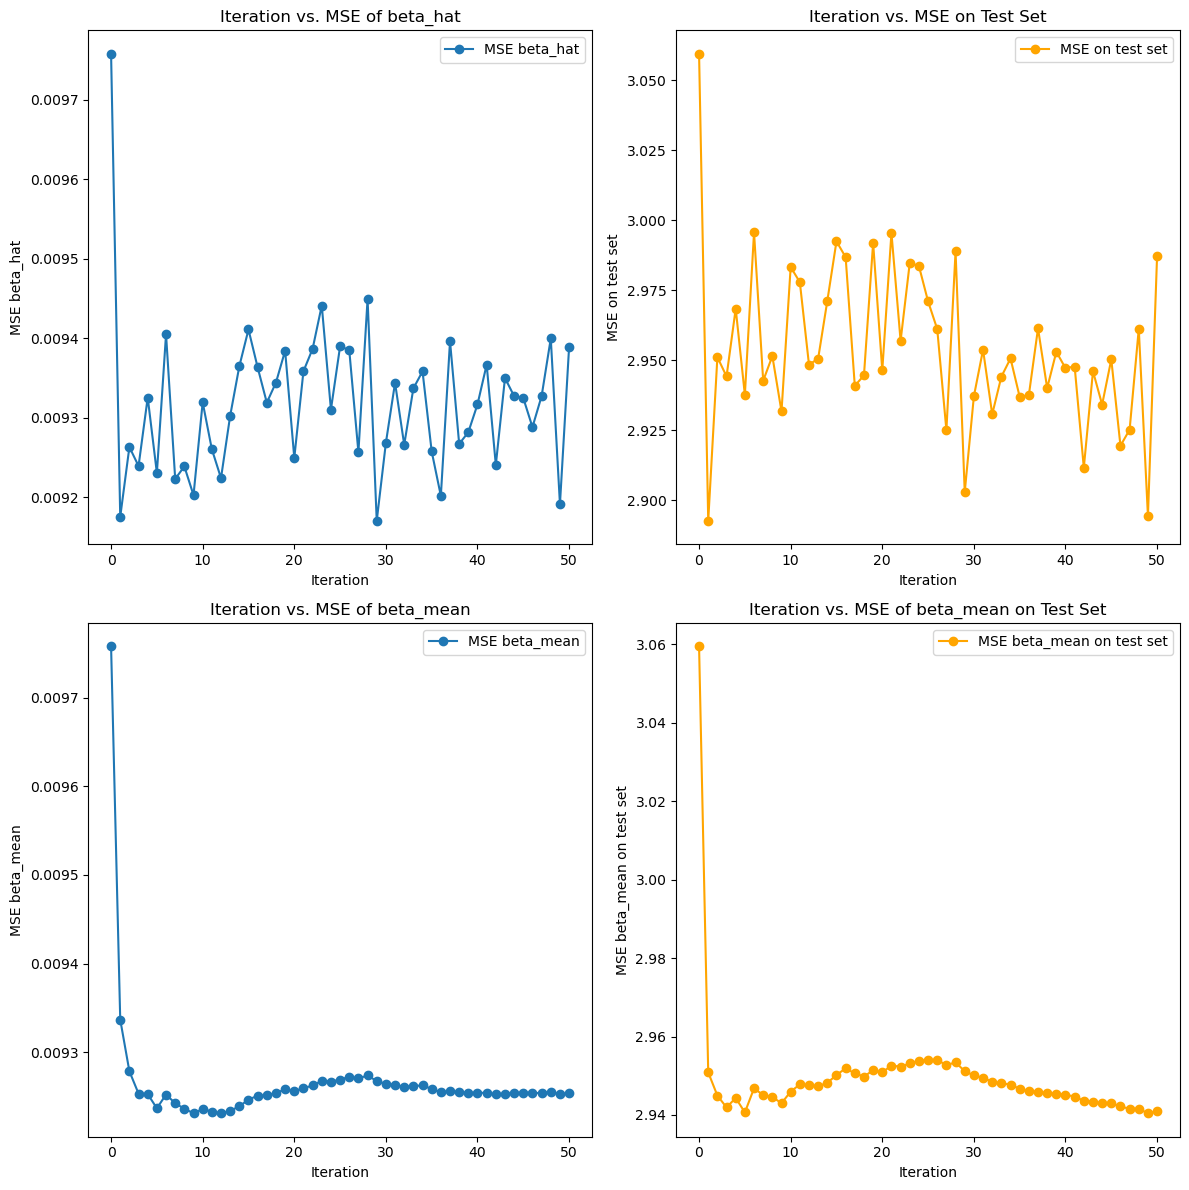

In [15]:
iter = 50
n = 10 # 选择前n个最大残差
k = 5 # 每次随机删除的点数
m = 12  # 重复次数
# Calculate residuals and set weights
weights = np.ones(train_size)
beta_history = [beta_hat_orignal]
beta_hat = beta_hat_orignal
MSE_history = [MSE_beta_hat_original]
MSE_test_history = [MSE_test_original]
MSE_beta_mean_history = [MSE_beta_hat_original]
MSE_beta_mean_test_history = [MSE_test_original]

# 迭代
for iteration in range(iter):
    Y_resid = np.abs(Y1 - X1.dot(beta_hat))
    
    # 标识最大残差的索引
    largest_residual_indices = np.argsort(Y_resid * weights)[-n:]  # 取最大的两个残差索引
    
    betas = []
    for _ in range(m):  # 多次重复取平均
        weights_temp = weights.copy()
        delete_indices = np.random.choice(largest_residual_indices, k, replace=False)
        weights_temp[delete_indices] = 0
        
        # 计算加权最小二乘法的回归系数
        W = np.diag(weights_temp)
        X_transpose_W = X1.T.dot(W)
        X_transpose_W_X = X_transpose_W.dot(X1)
        X_transpose_W_X_inv = np.linalg.inv(X_transpose_W_X)
        X_transpose_W_Y = X_transpose_W.dot(Y1)
        beta_hat_temp = X_transpose_W_X_inv.dot(X_transpose_W_Y)
        betas.append(beta_hat_temp)
    
    # 当前迭代的beta取平均
    beta_hat = np.mean(betas, axis=0)
    
    # 记录系数和MSE
    beta_history.append(beta_hat)
    MSE_beta_hat = np.mean((beta_hat - true_beta) ** 2)
    MSE_history.append(MSE_beta_hat)
    
    # 在测试集上预测
    Y_test_pred = X_test.dot(beta_hat)
    Y_test_resid = Y_test - Y_test_pred
    MSE_test = np.mean(Y_test_resid ** 2)
    MSE_test_history.append(MSE_test)

    beta_mean = np.mean(beta_history, axis=0)
    MSE_beta_mean = np.mean((beta_mean - true_beta) ** 2)
    MSE_beta_mean_history.append(MSE_beta_mean)
    Y_beta_mean_test_pred = X_test.dot(beta_mean)
    Y_beta_mean_test_resid = Y_test - Y_beta_mean_test_pred
    MSE_beta_mean_test = np.mean(Y_beta_mean_test_resid ** 2)
    MSE_beta_mean_test_history.append(MSE_beta_mean_test)

# 绘制迭代次数和MSE的关系图
iterations = list(range(iter+1))  # 包含初始值的0次迭代

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(iterations, MSE_history, marker='o', label='MSE beta_hat')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_hat')
plt.title('Iteration vs. MSE of beta_hat')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iterations, MSE_test_history, marker='o', label='MSE on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE on test set')
plt.title('Iteration vs. MSE on Test Set')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iterations, MSE_beta_mean_history, marker='o', label='MSE beta_mean')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean')
plt.title('Iteration vs. MSE of beta_mean')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iterations, MSE_beta_mean_test_history, marker='o', label='MSE beta_mean on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean on test set')
plt.title('Iteration vs. MSE of beta_mean on Test Set')
plt.legend()

plt.tight_layout()
plt.show()

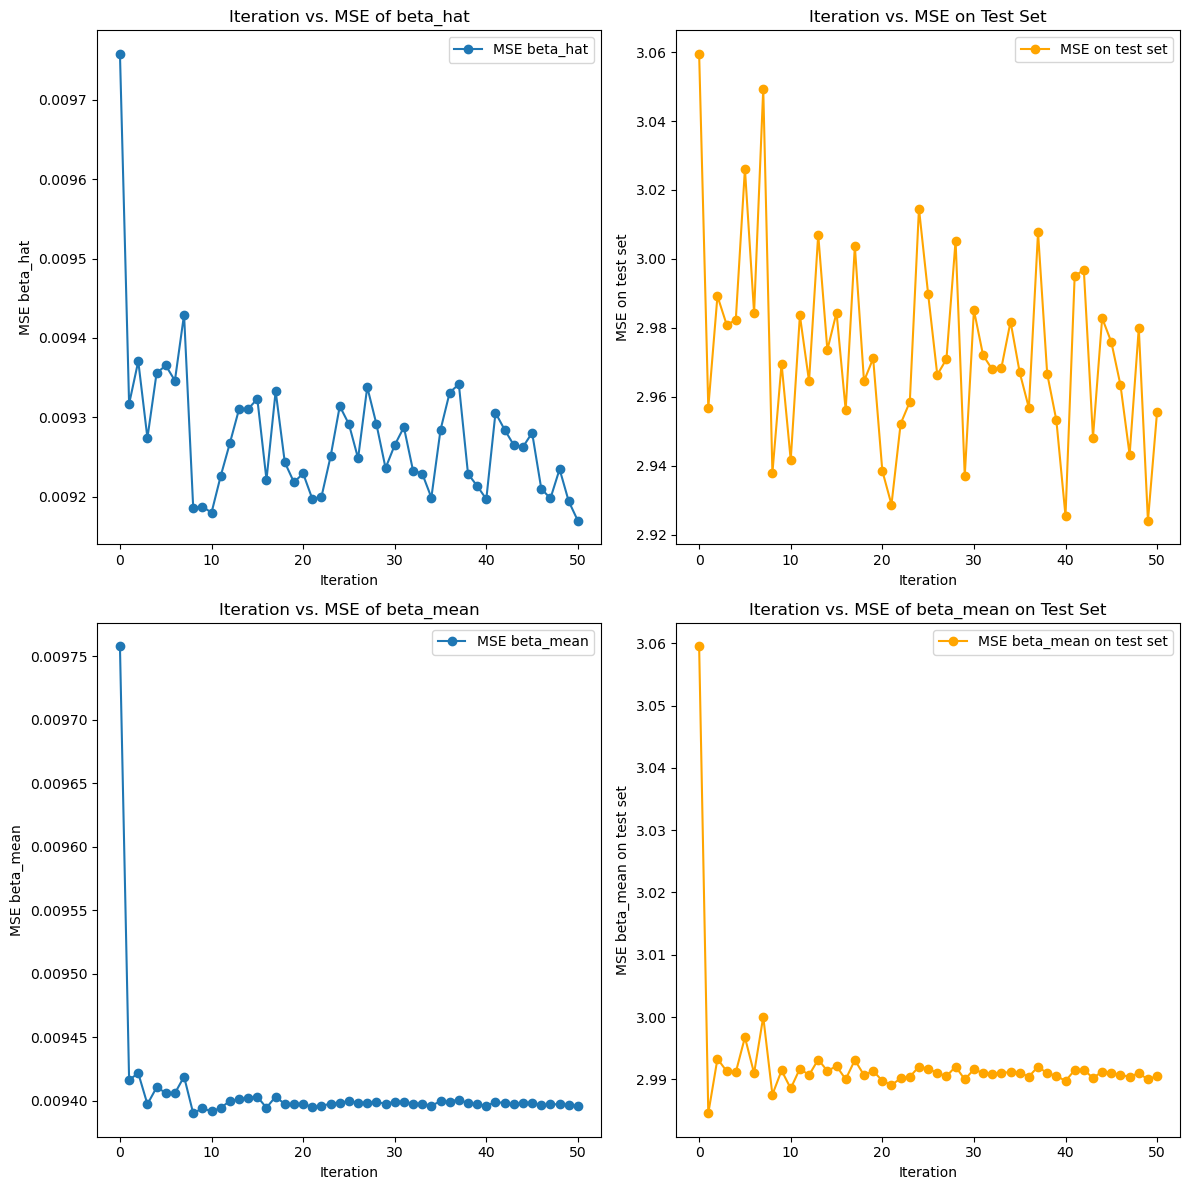

In [16]:
iter = 50
n = 10 # 选择前n个最大残差
k = 5 # 每次随机删除的点数
m = 12  # 重复次数
# Calculate residuals and set weights
weights = np.ones(train_size)
beta_history = [beta_hat_orignal]
beta_hat = beta_hat_orignal
MSE_history = [MSE_beta_hat_original]
MSE_test_history = [MSE_test_original]
MSE_beta_mean_history = [MSE_beta_hat_original]
MSE_beta_mean_test_history = [MSE_test_original]

# 迭代
for iteration in range(iter):
    Y_resid = np.abs(Y1 - X1.dot(beta_hat))
    
    # 标识最大残差的索引
    largest_residual_indices = np.argsort(Y_resid * weights)[-n:]  # 取最大的两个残差索引
    
    betas = []
    for _ in range(m):  # 多次重复取平均
        weights_temp = weights.copy()
        delete_indices = np.random.choice(largest_residual_indices, k, replace=False)
        weights_temp[delete_indices] = 0
        
        # 计算加权最小二乘法的回归系数
        W = np.diag(weights_temp)
        X_transpose_W = X1.T.dot(W)
        X_transpose_W_X = X_transpose_W.dot(X1)
        X_transpose_W_X_inv = np.linalg.inv(X_transpose_W_X)
        X_transpose_W_Y = X_transpose_W.dot(Y1)
        beta_hat_temp = X_transpose_W_X_inv.dot(X_transpose_W_Y)
        betas.append(beta_hat_temp)
    
    # 当前迭代的beta取平均
    beta_hat = np.mean(betas, axis=0)
    
    # 记录系数和MSE
    beta_history.append(beta_hat)
    MSE_beta_hat = np.mean((beta_hat - true_beta) ** 2)
    MSE_history.append(MSE_beta_hat)
    
    # 在测试集上预测
    Y_test_pred = X_test.dot(beta_hat)
    Y_test_resid = Y_test - Y_test_pred
    MSE_test = np.mean(Y_test_resid ** 2)
    MSE_test_history.append(MSE_test)

    beta_mean = np.mean(beta_history, axis=0)
    beta_history[-1] = beta_mean#更新最新的beta_hat
    MSE_beta_mean = np.mean((beta_mean - true_beta) ** 2)
    MSE_beta_mean_history.append(MSE_beta_mean)
    Y_beta_mean_test_pred = X_test.dot(beta_mean)
    Y_beta_mean_test_resid = Y_test - Y_beta_mean_test_pred
    MSE_beta_mean_test = np.mean(Y_beta_mean_test_resid ** 2)
    MSE_beta_mean_test_history.append(MSE_beta_mean_test)

# 绘制迭代次数和MSE的关系图
iterations = list(range(iter+1))  # 包含初始值的0次迭代

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(iterations, MSE_history, marker='o', label='MSE beta_hat')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_hat')
plt.title('Iteration vs. MSE of beta_hat')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iterations, MSE_test_history, marker='o', label='MSE on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE on test set')
plt.title('Iteration vs. MSE on Test Set')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iterations, MSE_beta_mean_history, marker='o', label='MSE beta_mean')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean')
plt.title('Iteration vs. MSE of beta_mean')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iterations, MSE_beta_mean_test_history, marker='o', label='MSE beta_mean on test set', color='orange')
plt.xlabel('Iteration')
plt.ylabel('MSE beta_mean on test set')
plt.title('Iteration vs. MSE of beta_mean on Test Set')
plt.legend()

plt.tight_layout()
plt.show()